In [1]:
import sys
import os
import time
import warnings
import pickle

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rcParams
from cycler import cycler
from matplotlib import ticker
from structure_factor.point_pattern import PointPattern
from structure_factor.spatial_windows import BoxWindow, BallWindow
from structure_factor.hyperuniformity import bin_data, hyperuniformity_class
from structure_factor.data import load_data
from structure_factor.point_processes import GinibrePointProcess
from structure_factor.structure_factor import StructureFactor
import structure_factor.pair_correlation_function as pcf
from structure_factor.tapers import multi_sinetaper_grid
from structure_factor.utils import meshgrid_to_column_matrix
from structure_factor.tapered_estimators import allowed_k_scattering_intensity, scattering_intensity, tapered_estimator_debiased_direct

import massPy as mp
from utils import get_defect_list, get_defect_arr_from_frame, get_frame_number, do_chi2_fit, gen_analysis_dict
from AnalyseDefects_dev import AnalyseDefects

## Set plotting style and print options
plt.style.use('sg_article')
np.set_printoptions(precision = 5, suppress=1e-10)

In [22]:
def get_pair_corr_function(ar, ar_path, ball_window, frame_interval = None, method = "fv", \
                            kest_kwargs = {'rmax': 10, 'correction': 'best', 'var.approx': False},\
                                method_kwargs = dict(method="b", spar=0.2, nknots=40)):
    """
    Calculate pair correlation function for the frames in frame_interval
    """

    # Get number of frames
    Nframes = ar.__dict__['num_frames'] if frame_interval is None else frame_interval[1] - frame_interval[0]
    frame_interval = [0, Nframes - 1] if frame_interval is None else frame_interval

    # Extract LX, LY from first frame
    frame = ar._read_frame(frame_interval[0])
    LX, LY = frame.LX, frame.LY

    # Get defect list
    defect_list = get_defect_list(ar, frame_interval[0], Nframes, archive_path=ar_path)

    for i, frame in enumerate(range(frame_interval[0], frame_interval[1])):

        # Get defect array for frame
        defect_positions = get_defect_arr_from_frame(defect_list[i])

        # Initialize point pattern
        point_pattern = PointPattern(defect_positions, ball_window)

        # Calculate pair correlation function
        pcf_estimated = pcf.estimate(point_pattern, method=method, \
                                 Kest=kest_kwargs, fv=method_kwargs)
        
        # Store results
        if i == 0:
            rad_arr = pcf_estimated.r.values
            pcf_arr = np.empty([Nframes, len(rad_arr)])
        pcf_arr[i] = pcf_estimated.pcf

    return rad_arr, pcf_arr

def get_pair_corr_from_defect_list(defect_list, ball_window, frame_idx_interval = None, method = "fv", \
                            kest_kwargs = {'rmax': 10, 'correction': 'best', 'var.approx': False},\
                                method_kwargs = dict(method="b", spar=0.2, nknots=40), save=False, save_dir=None, save_suffix=None):
    """
    Calculate pair correlation function for the frames in frame_interval
    """

    # Get number of frames
    Nframes = len(defect_list) if frame_idx_interval is None else frame_idx_interval[1] - frame_idx_interval[0]
    frame_interval = [0, Nframes - 1] if frame_idx_interval is None else frame_idx_interval

    for i, frame in enumerate(range(frame_interval[0], frame_interval[1])):

        # Get defect array for frame
        defect_positions = get_defect_arr_from_frame(defect_list[frame])

        # Initialize point pattern
        point_pattern = PointPattern(defect_positions, ball_window)

        # Calculate pair correlation function
        pcf_estimated = pcf.estimate(point_pattern, method=method, \
                                 Kest=kest_kwargs, fv=method_kwargs)
        
        # Store results
        if i == 0:
            rad_arr = pcf_estimated.r.values
            pcf_arr = np.empty([Nframes, len(rad_arr)])
        pcf_arr[i] = pcf_estimated.pcf

    if save:
        if save_dir is not None:
            if not os.path.isdir(save_dir):
                os.makedirs(save_dir)
        np.save(save_dir + f'rad_arr{save_suffix}.npy', rad_arr)
        np.save(save_dir + f'pcf_arr{save_suffix}.npy', pcf_arr)

    return rad_arr, pcf_arr

def calc_pair_corr_function(defect_arr, ball_window, method = 'fv', \
                            kest_kwargs = {'rmax': 10, 'correction': 'best', 'var.approx': False},\
                                method_kwargs = dict(method="b", spar=0.2, nknots=40),):
    """
    Calculate pair correlation function for a single frame
    """

    # Initialize point pattern
    point_pattern = PointPattern(defect_arr, ball_window)

    # Calculate pair correlation function
    pcf_estimated = pcf.estimate(point_pattern, method=method, \
                                 Kest=kest_kwargs, fv=method_kwargs)


    return pcf_estimated

def plot_pair_corr_function(pcf_estimated = None, rad_arr = None, pcf_arr = None, frame = None, plot_norm = False):
    """
    Plot pair correlation function
    """
    if isinstance(pcf_estimated, pd.DataFrame):
        r = pcf_estimated.r
        g = pcf_estimated.pcf
    else:
        try:
            r = rad_arr
            g = pcf_arr
        except:
            raise ValueError("No pair correlation function data provided")

    if plot_norm:
        g = np.abs(g)

    title = "Pair correlation function" if frame is None else "Pair correlation function, frame = {}".format(frame)

    fig, ax = plt.subplots()
    ax.plot(r, g, '-')
    ax.set_xlabel(rf"$r$ (radius of observation window)")
    ax.set_ylabel(rf"$g(r)$")
    ax.set_title(title)
    return fig, ax

def calc_structure_factor(defect_arr, box_window, kmax, debiased = True, direct = True, nbins = 50):
    """
    Calculate structure factor for a single frame
    """
    # Initialize point pattern
    point_pattern = PointPattern(defect_arr, box_window)
    sf = StructureFactor(point_pattern)
    k, sf_estimated = sf.scattering_intensity(k_max=kmax, debiased=debiased, direct=direct)

    # Bin data
    knorms = np.linalg.norm(k, axis=1)
    kbins, smeans, sstds = bin_data(knorms, sf_estimated, bins=nbins,)

    return k, sf_estimated, kbins, smeans, sstds

def plot_structure_factor(kbins, smeans, sstds, k = None, plot_scaling=False, LX = None, sf_estimated = None):
    """
    Plot structure factor
    """

    k_begin_lines_idx = 10
    kmin, kmax = np.nanmin(kbins), np.nanmax(kbins)
    sf_min, sf_max = np.nanmin(smeans), np.nanmax(smeans)
    x = np.linspace(kmin, kbins[k_begin_lines_idx], 10)

    fig, ax = plt.subplots()
    
    if k and sf_estimated:
        ax.scatter(np.linalg.norm(k, axis = 1), sf_estimated, label='Structure factor', s=2.5, alpha=0.3)

    ax.hlines(1, x[0], kmax, label=r'Possion', linestyles='dashed', colors='k')
    ax.errorbar(kbins, smeans, yerr = sstds, fmt = 's-', label = 'Binned means', alpha = .8, color = 'red', ecolor = 'black', markersize = 5)

    if plot_scaling:
        ax.plot(x, smeans[k_begin_lines_idx] * x**0.1 / x[-1]**0.1, label=r'$k^{0.1}$')
        ax.plot(x, smeans[k_begin_lines_idx] * x**0.2 / x[-1]**0.2, label=r'$k^{0.2}$')
        ax.plot(x, smeans[k_begin_lines_idx] * x**0.3 /x[-1]**0.3, label=r'$k^{0.3}$')

    ax.set_xscale('log')
    ax.set_yscale('log')
 #   ax.set_xticks(np.logspace(np.log10(kmin), np.log10(kmax), 5), np.round(np.logspace(np.log10(kmin), np.log10(kmax), 5),3))   
    
 #   ax.set_ylim([sf_min/4, sf_max + 3])
  #  ax.set_xlim([kmin - 0.01, kmax + 0.1])
    ax.legend(ncol=3, fontsize = 14)
    ax.set_xlabel(r'Norm of wavenumber ($k$)')
    ax.set_ylabel(r'Time av. structure factor')

    if LX == 2048:
            ax.set_xticks([kmin, 0.01, 0.1, kmax], [np.round(kmin,3), 0.01, 0.1, np.round(kmax,1)])
            ax.set_yticks([0.3, 0.4, 0.6, 1, 5], [0.3, 0.4, 0.6, 1, 5])
    else:
        ax.set_xticks([kmin, 0.1, kmax], [np.round(kmin,3), 0.1, np.round(kmax,1)])
    #    ax.set_yticks([0.3, 0.4, 0.6, 1,], [0.3, 0.4, 0.6, 1,])

    return fig, ax

def get_structure_factor(ar, box_window, LX = None, frame_interval = None, kmax = 1, debiased = True, direct = True, nbins = 50,):
    """
    Calculate structure factor for the frames in frame_interval
    """

    # Get number of frames
    Nframes = ar.__dict__['num_frames'] if frame_interval is None else frame_interval[1] - frame_interval[0]
    frame_interval = [0, Nframes - 1] if frame_interval is None else frame_interval

    if LX is None:
        # Extract LX, LY from first frame
        frame = ar._read_frame(frame_interval[0])
        LX, LY = frame.LX, frame.LY
    else:
        LY = LX

    # Initialize structure factor
    sf_arr = None

    # Get defect list
    defect_list = get_defect_list(ar, LX, LY, frame_interval[0], Nframes)

    for i, frame in enumerate(range(frame_interval[0], frame_interval[1])):

        # Get defect array for frame
        defect_positions = get_defect_arr_from_frame(defect_list[frame])

        if defect_positions is None:
            continue

        # Initialize point pattern
        point_pattern = PointPattern(defect_positions, box_window)
        t1 = time.time()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)

            sf = StructureFactor(point_pattern)
            k, sf_estimated = sf.scattering_intensity(k_max=kmax, debiased=debiased, direct=direct)
            
        t2 = time.time()
        print("Time for structure factor: {}".format(t2 - t1))

        # Calculate pair correlation function
    #    pcf_estimated = pcf.estimate(point_pattern, method='fv', \
     #                            Kest=dict(rmax=10), fv=dict(method="b", spar=0.2))
        t3 = time.time()
        print("Time for pair correlation function: {}".format(t3 - t2))

        # Bin data
        knorms = np.linalg.norm(k, axis=1)
        kbins, smeans, sstds = bin_data(knorms, sf_estimated, bins=nbins,)

        # Store results
        if sf_arr is None:
            kbins_arr = kbins.astype('float')
            sf_arr = np.zeros([Nframes, len(kbins_arr), 2]) * np.nan
   
        sf_arr[i, :, 0] = smeans
        sf_arr[i, :, 1] = sstds

    return kbins_arr, sf_arr


def get_structure_factor_from_arr_list(arr_list, box_window, LX, frame_interval = None, 
                                       kmax = 1, debiased = True, direct = True, nbins = 50,
                                       verbose=False):
    """
    Calculate structure factor for the frames in frame_interval
    """

    # Get number of frames
    Nframes = len(arr_list) if frame_interval is None else frame_interval[1] - frame_interval[0]
    frame_interval = [0, Nframes - 1] if frame_interval is None else frame_interval

    LY = LX

    # Initialize structure factor
    sf_arr = None

    for i, frame in enumerate(range(frame_interval[0], frame_interval[1])):
        if i % 100 == 0: 
            print(f"Processing frame {i} of {Nframes}...")
        # Get defect array for frame
        defect_positions = arr_list[frame]

        if defect_positions is None:
            continue

        # Initialize point pattern
        point_pattern = PointPattern(defect_positions, box_window)
        t1 = time.time()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)

            sf = StructureFactor(point_pattern)
            k, sf_estimated = sf.scattering_intensity(k_max=kmax, debiased=debiased, direct=direct)
            
        t2 = time.time()
        if verbose: print("Time for structure factor: {}".format(t2 - t1))

        # Calculate pair correlation function
       # pcf_estimated = pcf.estimate(point_pattern, method='fv', \
       #                          Kest=dict(rmax=10), fv=dict(method="b", spar=0.2))
        t3 = time.time()
        if verbose: print("Time for pair correlation function: {}".format(t3 - t2))

        # Bin data
        knorms = np.linalg.norm(k, axis=1)
        kbins, smeans, sstds = bin_data(knorms, sf_estimated, bins=nbins,)

        # Store results
        if sf_arr is None:
            kbins_arr = kbins.astype('float')
            sf_arr = np.zeros([Nframes, len(kbins_arr), 2]) * np.nan
   
        sf_arr[i, :, 0] = smeans
        sf_arr[i, :, 1] = sstds

    return kbins_arr, sf_arr




In [11]:
LL = 1024
output_path = f'data\\nematic_analysis{LL}_LL0.05'
mode = 'all' # 'all' or 'short'

defect_dir_list = gen_analysis_dict(LL, mode)

ad = AnalyseDefects(defect_dir_list, output_path=output_path)

In [7]:
N = 0
kbins, sfac, rad = ad.get_sfac_pcf(Ndataset = N, time_av=False, weighted=False)[:3]
sfac_tav = ad.get_sfac_pcf(Ndataset = N, time_av=True,)[1]
output_path = ad.output_paths[N]
fitp = np.load(f'{output_path}\\fit_params_sfac.npy')
fitp_unweighted = np.load(f'{output_path}\\fit_params_sfac_unweighted.npy')
sfac_full = np.load(f'{output_path}\\sfac.npy')
act_list = ad.act_list[N]

In [ ]:
path = 'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\def_pos512'
save_path = path
save_file = os.path.join(save_path, 'array_dict.pkl')

extract = False

def_list_list = []
order_list = []

array_dict = {}

if extract:
    if len(def_list_list) == 0: 
        for i, dir in enumerate(os.listdir(path)):
            order_list.append(int(dir))
            path_full = os.path.join(path, dir, 'defect_positions.pkl')
            with open(path_full, 'rb') as f:
                def_list = pickle.load(f)
            def_list_list.append(def_list)

    for i, def_list in enumerate(def_list_list):


        array_list_full = []
        array_list_neg = []
        array_list_pos = []

        Nframes = len(def_list)

        for Nframe in range(Nframes):

            defect_arr = get_defect_arr_from_frame(def_list[Nframe], return_charge=True)

            array_list_full.append(defect_arr[:,:2])
            array_list_neg.append(defect_arr[defect_arr[:, 2] < 0, :2]) 
            array_list_pos.append(defect_arr[defect_arr[:, 2] > 0, :2])


        array_dict[order_list[i]] = {'arr_list_full': array_list_full,
                                    'arr_list_neg': array_list_neg,
                                    'arr_list_pos': array_list_pos}
    # save array_dict
    with open(save_file, 'wb') as f:
        pickle.dump(array_dict, f)
else:
    # Load array_dict
    with open(save_file, 'rb') as f:
        array_dict = pickle.load(f)

In [21]:
save_dir = os.path.join(path, f'{order_list[0]}')
save_dir

'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\def_pos512\\22'

In [26]:
order_list, len(array_dict[act]['arr_list_full'])

([22, 24, 30, 60], 1501)

In [ ]:
act_idx = 0
order_list = list(array_dict.keys())


for act_idx, act  in enumerate(order_list):


    LX, LY = 512, 512
    LXB, LYB = 10, 10
    window = BoxWindow(bounds=[[0+LXB, LX-LXB], [0+LYB, LY-LYB]])  

    if act == 0.022:
        frame_interval = [1250, 1500]
    elif act == 0.024:
        frame_interval = [150, 400]
    else:
        frame_interval = [30, 180]

    kbins, sfac_full = get_structure_factor_from_arr_list(array_dict[act]['arr_list_full'],
                                                    box_window=window, LX=LX, frame_interval=frame_interval,)
    kbins, sfac_neg = get_structure_factor_from_arr_list(array_dict[act]['arr_list_neg'],
                                                    box_window=window, LX=LX, frame_interval=frame_interval,)
    kbins, sfac_pos = get_structure_factor_from_arr_list(array_dict[act]['arr_list_pos'],
                                                        box_window=window, LX=LX, frame_interval=frame_interval,)
    # Save results
    save_dir = os.path.join(path, f'{order_list[act_idx]}')
    np.save(os.path.join(save_dir,  'kbins.npy'), kbins)
    np.save(os.path.join(save_dir, 'sfac_full.npy'), sfac_full)
    np.save(os.path.join(save_dir, 'sfac_neg.npy'), sfac_neg)
    np.save(os.path.join(save_dir, 'sfac_pos.npy'), sfac_pos)               

In [28]:
sfac_pos.shape

(150, 50, 2)

In [ ]:
act_idx = 0
order_list = list(array_dict.keys())

for act_idx, act  in enumerate(order_list):
    fig, ax = plt.subplots()
    save_dir = os.path.join(path, f'{order_list[act_idx]}')
    kbins = np.load(os.path.join(save_dir, 'kbins.npy'))
    sfac_full = np.load(os.path.join(save_dir, 'sfac_full.npy'))
    sfac_neg = np.load(os.path.join(save_dir, 'sfac_neg.npy'))
    sfac_pos = np.load(os.path.join(save_dir, 'sfac_pos.npy'))
    # Plot structure factor
    sfac_full_time_av = np.nanmean(sfac_full[:,:,0], axis=0)
    sfac_neg_time_av = np.nanmean(sfac_neg[:,:,0], axis=0)
    sfac_pos_time_av = np.nanmean(sfac_pos[:,:,0], axis=0)
    sfac_full_std = np.nanmean(sfac_full[:,:,1], axis=0) / np.sqrt(sfac_full.shape[0])
    sfac_neg_std = np.nanmean(sfac_neg[:,:,1], axis=0) / np.sqrt(sfac_neg.shape[0])
    sfac_pos_std = np.nanmean(sfac_pos[:,:,1], axis=0) / np.sqrt(sfac_pos.shape[0])

    ax.errorbar(kbins, sfac_full_time_av, yerr=sfac_full_std, label='Full', fmt='o-', markersize=3, alpha=0.7)
    ax.errorbar(kbins, sfac_neg_time_av, yerr=sfac_neg_std, label='Negative', fmt='o-', markersize=3, alpha=0.7)
    ax.errorbar(kbins, sfac_pos_time_av, yerr=sfac_pos_std, label='Positive', fmt='o-', markersize=3, alpha=0.7)
    ax.set_xscale('log')
    ax.legend()
    ax.set_xlabel(r'Norm of wavenumber ($k$)')
    ax.set_ylabel(r'Time av. structure factor')
    ax.set_title(f'Act = {act}')
    fig.savefig(os.path.join(save_dir, 'sfac_plot.png'), dpi=420, bbox_inches='tight', pad_inches=0.1)

In [ ]:
LX, LY = 1024, 1024
path = 'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data'


### TEST TEST TEST
save_path = 'data\\nematic_analysis1024_LL0.05\\pair_corr_test\\'
save = True
load = True
data_dirs = os.listdir(path)

cluster_files = [f for f in data_dirs if f.startswith('na1024_a') and f.endswith('_cl')]
activity_list = [float('0.0' + f.split('_')[1][1:-2])  for f in cluster_files]
data_dirs = [os.path.join(path, d) for d in cluster_files]

# Sort data_dirs by activity
#data_dirs = [x for _, x in sorted(zip(activity_list, data_dirs))]
#activity_list.sort()

Ncl22 = 1
Ncl24 = 2
Ncl255 = 3

#ar = mp.archive.loadarchive(data_dirs[N])
activity_list, data_dirs 

In [97]:
min_dir_idx = 3
max_dir_idx = 5
test = False
Nframes = 25

LX, LY = 1024, 1024
LXB, LYB = 10, 10
window = BoxWindow(bounds=[[0+LXB, LX-LXB], [0+LYB, LY-LYB]])  


rmax = ((LX-LXB)/4 - 1) 
rmax = 60
nknots = int(rmax/2) # * int(rmax) # rmax # int(rmax / 2)

method = 'fv'
spar = 1.2  # .85
method_kwargs = dict(method="b", spar=spar, nknots=nknots)
kest_kwargs = {'rmax': rmax, 'correction': 'good', 'nlarge': 3000, 'var.approx': False}

rmax, nknots    


(60, 30)

In [5]:
Nframes = 300
first_frame_idx = 0
frame_interval_vl = [1100, 1100 + Nframes]# 1400]
frame_interval_l = [0, Nframes]#300]
frame_interval_sh = [0, min(180,Nframes)] #180
#Nframes = frame_interval[1] - frame_interval[0]
LX, LY = 1024, 1024
LXB, LYB = 10, 10
window = BoxWindow(bounds=[[0+LXB, LX-LXB], [0+LYB, LY-LYB]])  
rmax = ((LX-LXB)/4 - 1) / 2 

method = 'fv'
spar = .85

method_kwargs = dict(method="b", spar=spar, nknots=25)
kest_kwargs = {'rmax': rmax, 'correction': 'best', 'nlarge': 'inf', 'var.approx': False}


In [ ]:
with open(os.path.join(data_dirs[Ncl], 'defect_positions.pkl'), 'rb') as f:
    defect_list = pickle.load(f)
rad_arr, pcf_arr = get_pair_corr_from_defect_list(defect_list, window, frame_idx_interval = frame_interval_vl, method = "fv", \
                         kest_kwargs = kest_kwargs,\
                         method_kwargs = method_kwargs, save=save, save_dir=save_path,\
                              save_suffix=f'22rm{int(rmax)}_spar{spar}_nf{Nframes}')

In [31]:
# load defect_positions.pkl from data_dirs[Ncl22]
with open(os.path.join(data_dirs[Ncl22], 'defect_positions.pkl'), 'rb') as f:
    defect_list22 = pickle.load(f)
with open(os.path.join(data_dirs[Ncl24], 'defect_positions.pkl'), 'rb') as f:
    defect_list24 = pickle.load(f)
with open(os.path.join(data_dirs[Ncl255], 'defect_positions.pkl'), 'rb') as f:
    defect_list255 = pickle.load(f)

In [ ]:
if load:
     rad_arr22 = np.load(save_path + f'rad_arr22rm{int(rmax)}_spar{spar}_nf{Nframes}.npy')
     pcf_arr22 = np.load(save_path + f'pcf_arr22rm{int(rmax)}_spar{spar}_nf{Nframes}.npy')
     rad_arr24 = np.load(save_path + f'rad_arr24rm{int(rmax)}_spar{spar}_nf{Nframes}.npy')
     pcf_arr24 = np.load(save_path + f'pcf_arr24rm{int(rmax)}_spar{spar}_nf{Nframes}.npy')
     rad_arr255 = np.load(save_path + f'rad_arr255rm{int(rmax)}_spar{spar}_nf{Nframes}.npy')
     pcf_arr255 = np.load(save_path + f'pcf_arr255rm{int(rmax)}_spar{spar}_nf{Nframes}.npy')
else:
     rad_arr22, pcf_arr22 = get_pair_corr_from_defect_list(defect_list22, window, frame_idx_interval = frame_interval_vl, method = "fv", \
                         kest_kwargs = kest_kwargs,\
                         method_kwargs = method_kwargs, save=save, save_dir=save_path,\
                              save_suffix=f'22rm{int(rmax)}_spar{spar}_nf{Nframes}')
     rad_arr24, pcf_arr24 = get_pair_corr_from_defect_list(defect_list24, window, \
                         frame_idx_interval = frame_interval_l, method = "fv", \
                         kest_kwargs = kest_kwargs, method_kwargs = method_kwargs, \
                              save=save, save_dir=save_path, save_suffix=f'24rm{int(rmax)}_spar{spar}_nf{Nframes}')
     rad_arr255, pcf_arr255 = get_pair_corr_from_defect_list(defect_list255, window, \
                         frame_idx_interval = frame_interval_sh, method = "fv", \
                         kest_kwargs = kest_kwargs, method_kwargs = method_kwargs, \
                              save=save, save_dir=save_path, save_suffix=f'255rm{int(rmax)}_spar{spar}_nf{Nframes}')
pcf22_av = np.nanmean(pcf_arr22, axis = 0) - 1 
pcf24_av = np.nanmean(pcf_arr24, axis = 0) - 1
pcf22_std = np.nanstd(pcf_arr22, axis = 0)
pcf24_std = np.nanstd(pcf_arr24, axis = 0)
pcf255_av = np.nanmean(pcf_arr255, axis = 0) - 1
pcf255_std = np.nanstd(pcf_arr255, axis = 0)


In [ ]:
Nframes = 200
pcf22_av = np.nanmean(pcf_arr22[:Nframes], axis = 0) - 1 
pcf24_av = np.nanmean(pcf_arr24[:Nframes], axis = 0) - 1
pcf22_std = np.nanstd(pcf_arr22[:Nframes], axis = 0) / np.sqrt(pcf_arr22[-Nframes:].shape[0])
pcf24_std = np.nanstd(pcf_arr24[:Nframes], axis = 0) / np.sqrt(pcf_arr24[-Nframes:].shape[0])
pcf255_av = np.nanmean(pcf_arr255[:min(Nframes,180)], axis = 0) - 1
pcf255_std = np.nanstd(pcf_arr255[:min(Nframes,180)], axis = 0) / np.sqrt(pcf_arr255.shape[0])

In [ ]:
x0 = 10
x0_22 = 20
fit_func = lambda r, A, B: A*np.exp(-B*(r-x0))
fit_func22 = lambda r, A, B: A*np.exp(-B*(r-x0))
param_guess = [-0.15, 2]
params_guess22 = [0.15, 1.2]
point_bounds = [50,250]
point_bounds24 = [50, 180]
point_bounds22 = [300, 400]
x255 = rad_arr255[point_bounds[0]:point_bounds[1]]
y255 = pcf255_av[point_bounds[0]:point_bounds[1]]
yerr255 = pcf255_std[point_bounds[0]:point_bounds[1]]
x24 = rad_arr24[point_bounds24[0]:point_bounds24[1]]
y24 = pcf24_av[point_bounds24[0]:point_bounds24[1]]
yerr24 = pcf24_std[point_bounds24[0]:point_bounds24[1]]
x22 = rad_arr22[point_bounds22[0]:point_bounds22[1]]
y22 = pcf22_av[point_bounds22[0]:point_bounds22[1]]
yerr22 = pcf22_std[point_bounds22[0]:point_bounds22[1]]

fit255 = do_chi2_fit(fit_func, x255, y255, yerr255, param_guess, verbose = False)
fit24 = do_chi2_fit(fit_func, x24, y24, yerr24, param_guess, verbose = False)
fit22 = do_chi2_fit(fit_func, x22, y22, yerr22, param_guess, verbose = False)
fit255.values[:], fit255.errors[:], fit22.values[:]

(0.0, 120.0)

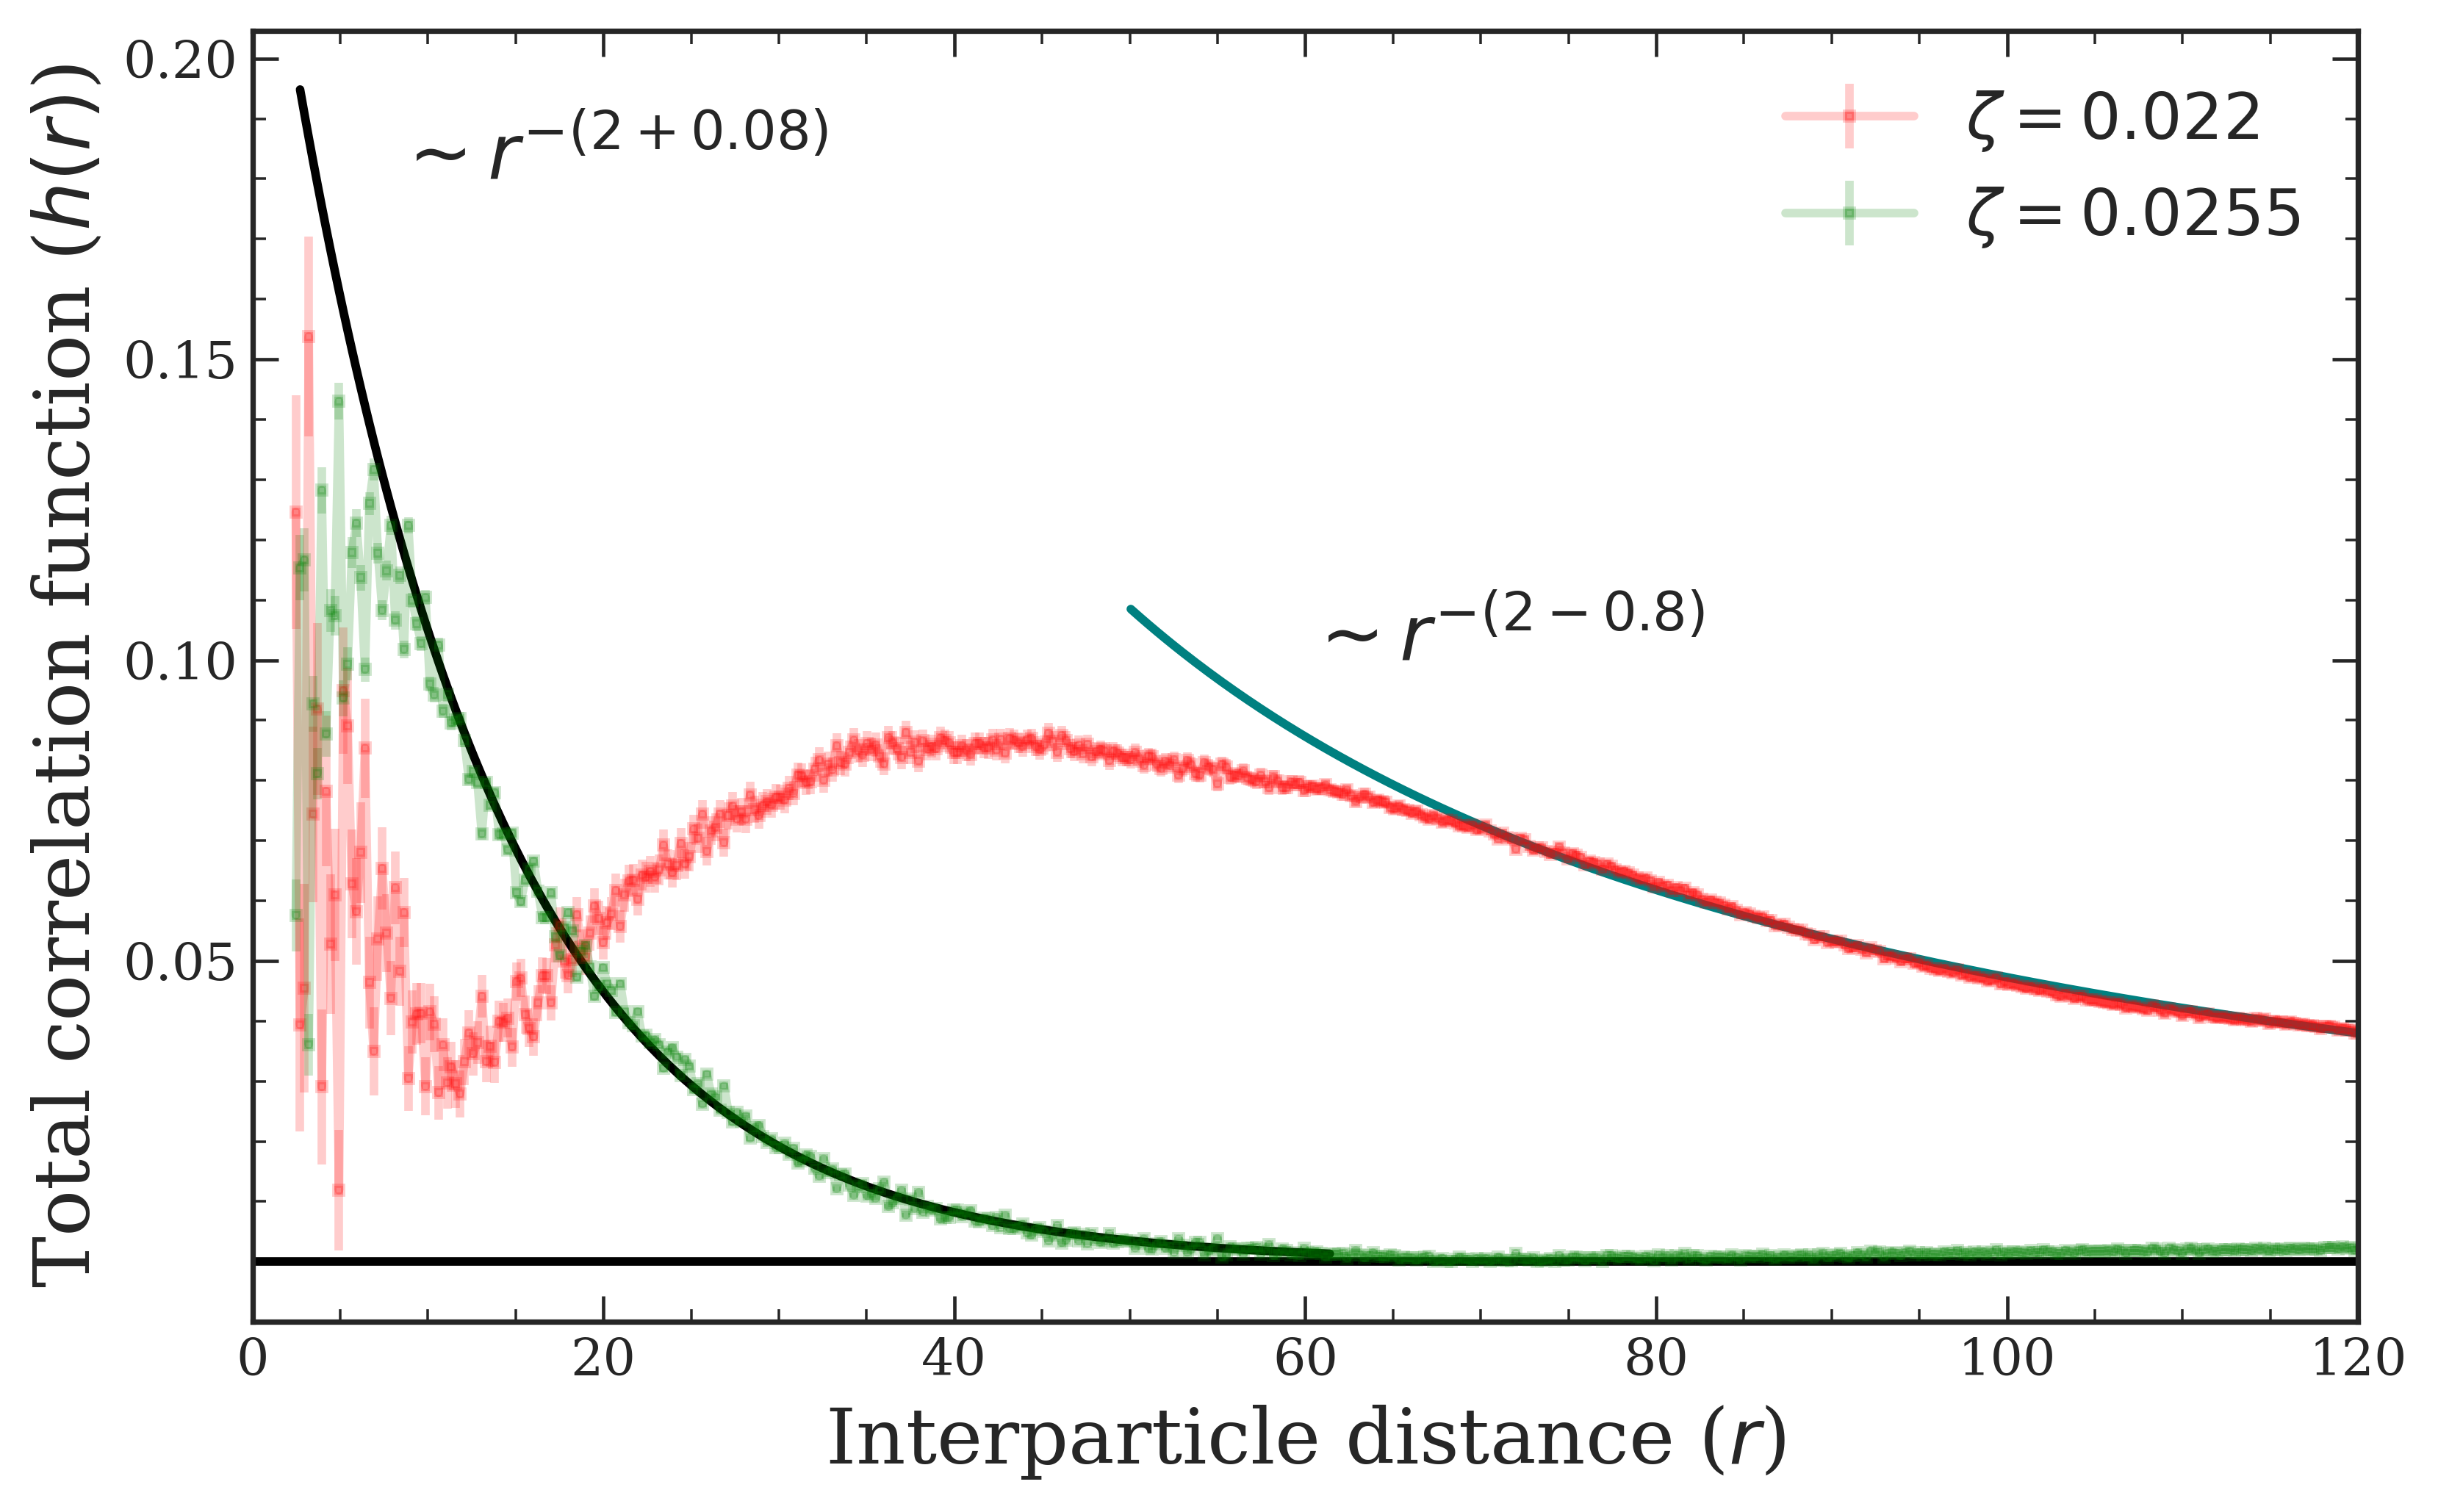

In [11]:
min_idx22 = 10
min_idx24 = 30
min_idx255 = 10

argmax22 = np.argmin(np.abs(rad_arr22-50))  

argmax24 = np.argmin(np.abs(rad_arr24-15)) # np.argmax(np.abs(pcf24_av[min_idx24:])) + min_idx24
argmax255 = np.argmax(np.abs(pcf255_av[min_idx255:])) + min_idx255
#fig, ax = plot_pair_corr_function(rad_arr = rad_arr22[min_idx22:], pcf_arr = pcf22_av[min_idx22:], plot_norm = False)
fig, ax = plt.subplots(figsize=(8,5 ))

#ax.plot(rad_arr24[min_idx24:], np.abs(pcf24_av[min_idx24:]), label = 'abs Ncl24')

ax.errorbar(rad_arr22[min_idx22:], pcf22_av[min_idx22:], yerr = pcf22_std[min_idx22:], fmt = 's-', \
            label = r'$\zeta = 0.022$', alpha = .2, color = 'red', markersize = 2)
#ax.errorbar(rad_arr24[min_idx24:], np.abs(pcf24_av[min_idx24:]), yerr = pcf24_std[min_idx24:],\
 #            fmt = 's-', label = 'Ncl24', alpha = .2, color = 'blue',  markersize = 2)
ax.errorbar(rad_arr255[min_idx255:], np.abs(pcf255_av[min_idx255:]), yerr = pcf255_std[min_idx255:],\
             fmt = 's-', label = r'$\zeta = 0.0255$', alpha = .2, color = 'green',  markersize = 2)
ax.hlines(0, 0, 120, linestyles='-', colors='k')

yticks = np.linspace(0.05, 0.2,4)
ax.set(yticks=yticks, yticklabels=[f'{y:.2f}' for y in yticks])
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))

alpha22 = -.8
alpha24 = - -.3 #.05
argmax24 += -50
#ax.plot(rad_arr24[argmax24:], 1*np.abs(pcf24_av[argmax24]) * rad_arr24[argmax24:]**(-2-alpha24) / rad_arr24[argmax24]**(-2-alpha24),\
  #       '-', label = r'$\sim r^{-1.9}$', markersize=3,alpha=1)
ax.plot(rad_arr22[argmax22:], 1.3*pcf22_av[argmax22] * rad_arr22[argmax22:]**(-2-alpha22) / rad_arr22[argmax22]**(-2-alpha22),\
         '-', ms=3, alpha=1)
#ax.plot(x255, np.abs(fit_func(x255, *fit255.values)), '-', label = r'$\sim r^{-(2+0.08)}$', ms=3, alpha=1, lw=2, color='black')
ax.plot(rad_arr24[argmax24:250], np.abs(fit_func(rad_arr24[argmax24:250], *fit255.values)), '-', ms=3, alpha=1, lw=2, color='black')
#ax.plot(x24, np.abs(fit_func(x24, *fit24.values)), '-', label = r'$\sim e^{-2(r-10)}$', ms=3, alpha=1, lw=2, color='black')
#ax.text(0.5, 0.5, f'$\zeta = 0.022$: $A = {fit22.values[0]:.2f}$, $B = {fit22.values[1]:.2f}$', transform=ax.transAxes)
ax.text(8,.18, r'$\sim r^{-(2 + 0.08)}$', fontsize=18) #, transform=ax.transAxes)
ax.text(60,.1, r'$\sim r^{-(2 - 0.8)}$', fontsize=18) #, transform=ax.transAxes)
ax.legend()
#ax.set_ylim(-.05,0.15)

ax.set_ylabel(r'Total correlation function ($h(r)$)')
ax.set_xlabel(r'Interparticle distance ($r$)')
ax.set_xlim(0, 120);

In [15]:
def produce_scaling(X, scaling_exp, Y0, x_bounds,):
    x = X[x_bounds[0]:x_bounds[1]]

    return x, Y0 * x**scaling_exp / x[0]**scaling_exp

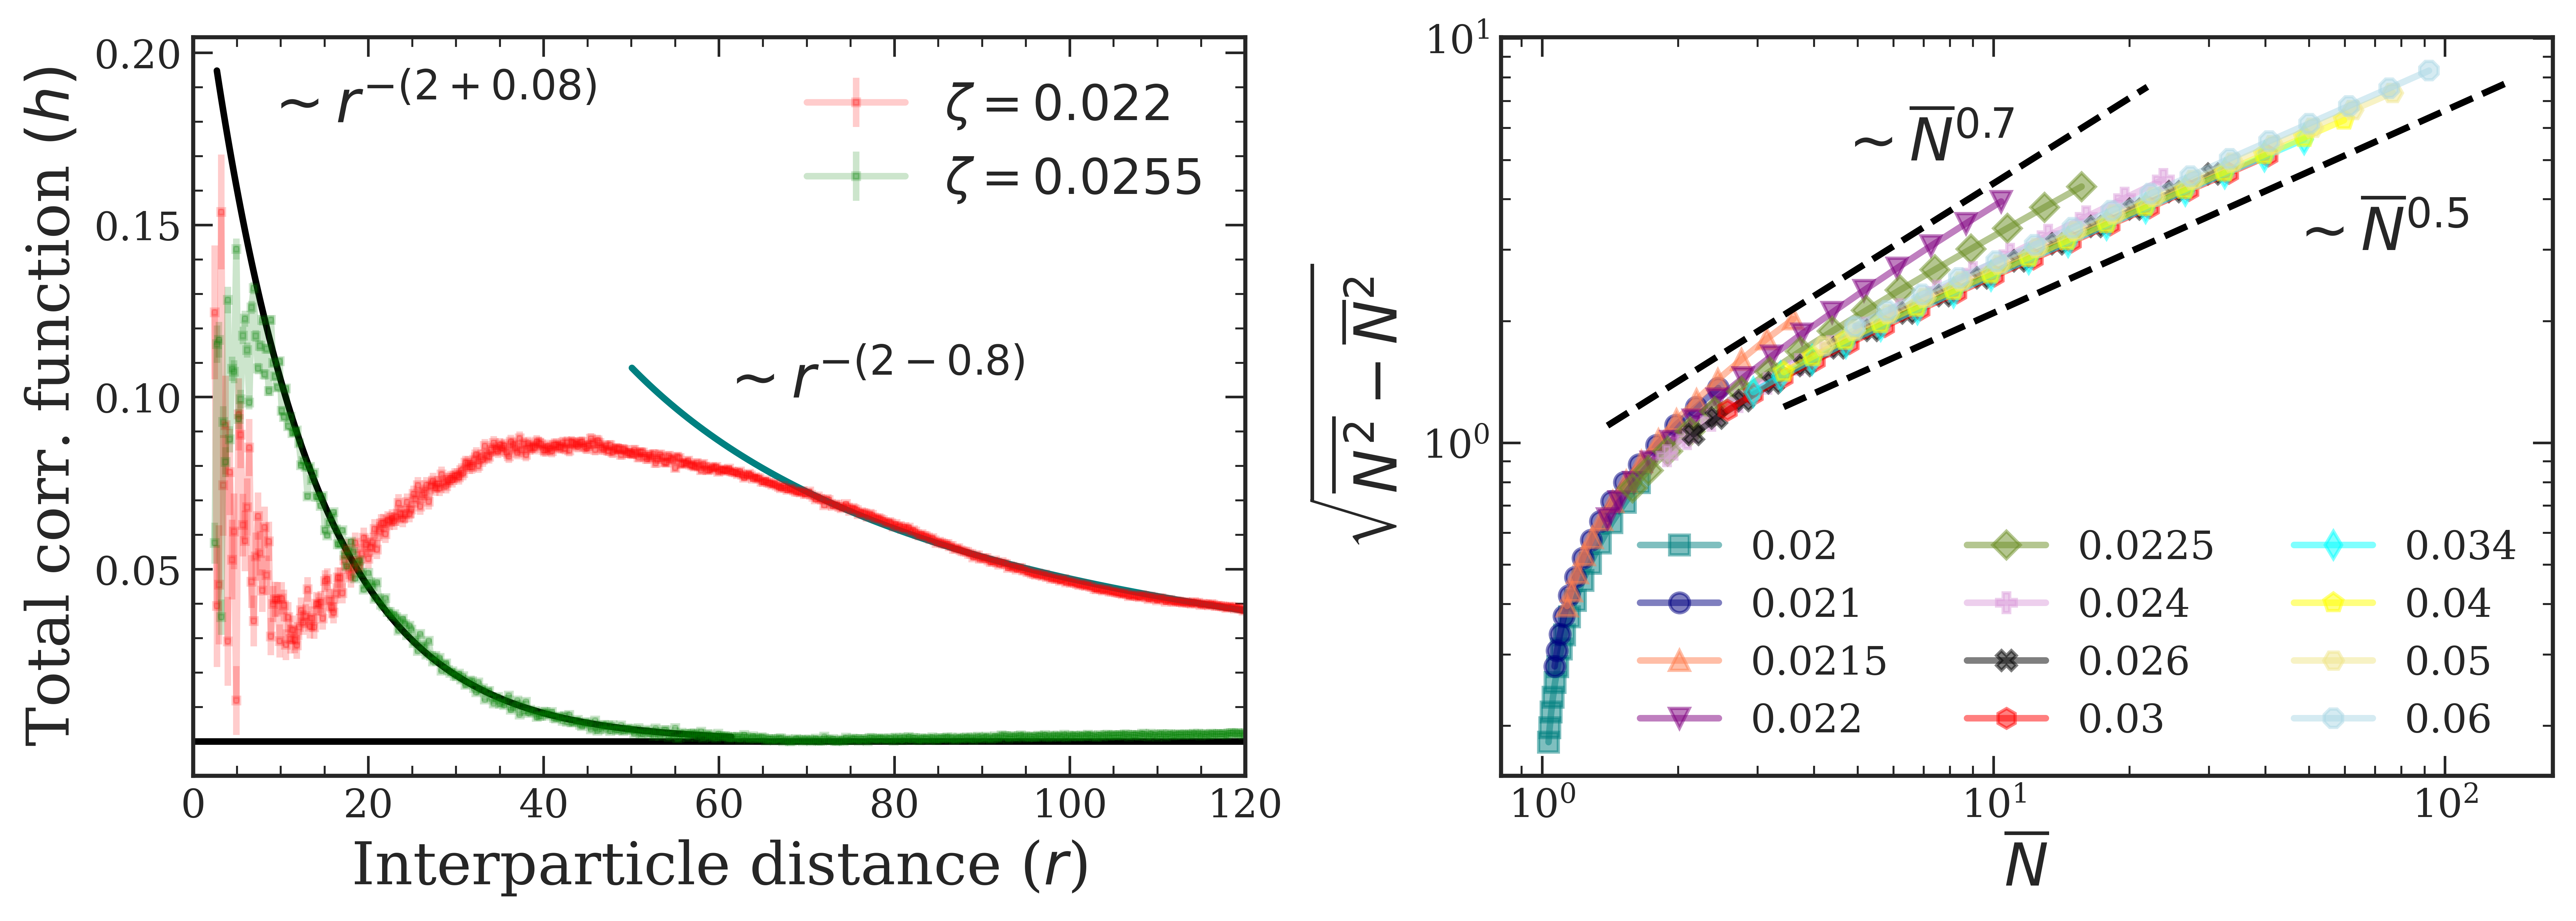

In [41]:

fig, ax0 = plt.subplots(nrows = 1, ncols = 2, figsize=(11,4)) 
marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']
ax0 = ax0.flatten()
ax = ax0[0]
axx = ax0[1]

min_idx22 = 10
min_idx24 = 30
min_idx255 = 10

argmax22 = np.argmin(np.abs(rad_arr22-50))  

argmax24 = np.argmin(np.abs(rad_arr24-15)) # np.argmax(np.abs(pcf24_av[min_idx24:])) + min_idx24
argmax255 = np.argmax(np.abs(pcf255_av[min_idx255:])) + min_idx255
#fig, ax = plot_pair_corr_function(rad_arr = rad_arr22[min_idx22:], pcf_arr = pcf22_av[min_idx22:], plot_norm = False)

#ax.plot(rad_arr24[min_idx24:], np.abs(pcf24_av[min_idx24:]), label = 'abs Ncl24')

ax.errorbar(rad_arr22[min_idx22:], pcf22_av[min_idx22:], yerr = pcf22_std[min_idx22:], fmt = 's-', \
            label = r'$\zeta = 0.022$', alpha = .2, color = 'red', markersize = 2)
#ax.errorbar(rad_arr24[min_idx24:], np.abs(pcf24_av[min_idx24:]), yerr = pcf24_std[min_idx24:],\
 #            fmt = 's-', label = 'Ncl24', alpha = .2, color = 'blue',  markersize = 2)
ax.errorbar(rad_arr255[min_idx255:], np.abs(pcf255_av[min_idx255:]), yerr = pcf255_std[min_idx255:],\
             fmt = 's-', label = r'$\zeta = 0.0255$', alpha = .2, color = 'green',  markersize = 2)
ax.hlines(0, 0, 120, linestyles='-', colors='k')

yticks = np.linspace(0.05, 0.2,4)
ax.set(yticks=yticks, yticklabels=[f'{y:.2f}' for y in yticks])
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))

alpha22 = -.8
alpha24 = - -.3 #.05
argmax24 += -50
#ax.plot(rad_arr24[argmax24:], 1*np.abs(pcf24_av[argmax24]) * rad_arr24[argmax24:]**(-2-alpha24) / rad_arr24[argmax24]**(-2-alpha24),\
  #       '-', label = r'$\sim r^{-1.9}$', markersize=3,alpha=1)
ax.plot(rad_arr22[argmax22:], 1.3*pcf22_av[argmax22] * rad_arr22[argmax22:]**(-2-alpha22) / rad_arr22[argmax22]**(-2-alpha22),\
         '-', ms=3, alpha=1, lw=2)
#ax.plot(x255, np.abs(fit_func(x255, *fit255.values)), '-', label = r'$\sim r^{-(2+0.08)}$', ms=3, alpha=1, lw=2, color='black')
ax.plot(rad_arr24[argmax24:250], np.abs(fit_func(rad_arr24[argmax24:250], *fit255.values)), '-', ms=3, alpha=1, lw=2, color='black')
#ax.plot(x24, np.abs(fit_func(x24, *fit24.values)), '-', label = r'$\sim e^{-2(r-10)}$', ms=3, alpha=1, lw=2, color='black')
#ax.text(0.5, 0.5, f'$\zeta = 0.022$: $A = {fit22.values[0]:.2f}$, $B = {fit22.values[1]:.2f}$', transform=ax.transAxes)
ax.text(8,.18, r'$\sim r^{-(2 + 0.08)}$', fontsize=18) #, transform=ax.transAxes)
ax.text(60,.1, r'$\sim r^{-(2 - 0.8)}$', fontsize=18) #, transform=ax.transAxes)
ax.legend()
#ax.set_ylim(-.05,0.15)

ax.set_ylabel(r'Total corr. function $(h)$')
ax.set_xlabel(r'Interparticle distance ($r$)')
ax.set_xlim(0, 120);



window_idx_bounds = [10,-4]
marker_shape = ['s', 'o', '^', 'v', 'D', 'P', 'X', 'h', 'd', 'p', 'H', '8', '1', '2']
act_list = ad.act_list[0]

acts_to_plot = [0.02, 0.021, 0.0215, 0.022, 0.0225, 0.024, 0.026, 0.03, 0.034, 0.04, 0.05, 0.06]
if ad.LX[0] == 2048:
    acts_to_plot = [0.02, 0.021, 0.0215, 0.022, 0.024, 0.026, 0.03, 0.034, 0.04, 0.05, 0.06]
for i, act in enumerate(acts_to_plot):
    idx = act_list.index(act)
    axx.plot(av_counts_av[window_idx_bounds[0]:window_idx_bounds[1],idx,0], np.sqrt(var_counts_av[window_idx_bounds[0]:window_idx_bounds[1],idx,0]),\
             label=f'{act}', marker=marker_shape[i], alpha=.5)


idx22 = act_list.index(0.022)
idx40 = act_list.index(0.040)
scaling22 = (1+0.8/2)/2
window_idx_bounds = [10,None]


#ax.plot(av_counts_av[:,idx,0], 0.8*av_counts_av[:,idx,0]**0.69, label=r'$\sim x^{0.7}$', color='black', lw=1.5, linestyle='--')
#ax.plot(av_counts_av[:,idx,0], 0.8*av_counts_av[:,idx,0]**0.5,label=r'$\sim x^{0.5}$', color='black', lw=1.5, linestyle='-')


x22, y22 = produce_scaling(av_counts_av[:, idx22, 0], scaling22, np.sqrt(var_counts_av[window_idx_bounds[0],idx22,0]), window_idx_bounds,)
x40, y40 = produce_scaling(av_counts_av[:, idx40, 0], .5, np.sqrt(var_counts_av[window_idx_bounds[0],idx40,0]), window_idx_bounds,)
axx.plot(x22, 1.7*y22, color='black', linestyle='--')
axx.plot(x40, y40*0.82,  color='black', linestyle='--')
axx.text(45,3, r'$\sim \overline{N}^{0.5}$', fontsize=18)
axx.text(4.5, 5, r'$\sim \overline{N}^{0.7}$', fontsize=18)

axx.set_xlabel(r'$\overline{N}$')
axx.set_ylabel(r'$\sqrt{\overline{N^2} - \overline{N}^2}$')
#ax.set_ylim(.5,8)
#ax.set_xlim(1,100)
axx.legend(ncols=3,fontsize=12)
axx.set_xscale('log')
axx.set_yscale('log')




fig.tight_layout()
fig.dpi = 720
#fig.savefig('data/nematic_analysis_all/susceptibility.eps', dpi = 720, pad_inches = .5)

In [ ]:
data_dirs = [os.path.join(path, dir_name) for dir_name in os.listdir(path)]
paths = [data_dirs[-6], data_dirs[-5], data_dirs[-4],]
act_list = [0.021, 0.022, 0.028,]
data_dirs, paths

In [ ]:
for pcf_vals in range(pcf_arr.shape[0]):
    fig, ax = plot_pair_corr_function(rad_arr = rad_arr, pcf_arr = pcf_arr[pcf_vals] - 1, plot_norm = False)
#fig, ax = plot_pair_corr_function(rad_arr = rad_arr, pcf_arr = pcf_av-1, plot_norm = False)

In [29]:
frame_interval = [0, 3]
Nframes = frame_interval[1] - frame_interval[0]
LX, LY = ar._read_frame(0).LX, ar._read_frame(0).LY
defect_list = get_defect_list(ar, LX, LY, frame_interval[0], Nframes)

In [ ]:
path = 'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data'

data_dirs = os.listdir(path)
data_dirs = [os.path.join(path, d) for d in data_dirs]

N = 7

In [ ]:
center_at_origin = False

LXB, LYB = LX/10,LY/10  
if center_at_origin:
    box_window = BoxWindow(bounds=[[-LX / 2 + LXB, LX/2 - LXB], [-LX / 2 + LXB, LX/2 - LXB]])  
else:
    box_window = BoxWindow(bounds=[[0+LXB, LX-LXB], [0+LYB, LY-LYB]])
kmax = .5
direct = True
debiased = True
Nframes = frame_interval[1] - frame_interval[0]
nbins = 50
Nf=4

sf_arr = np.zeros([Nframes, nbins, 2]) * np.nan

for i, frame in enumerate(range(Nf)):

    # Get defect array for frame
    defect_positions = get_defect_arr_from_frame(defect_list[i])

    if defect_positions is None:
        print(f'No defects in frame {frame}')
        continue

    if center_at_origin:
        defect_positions = defect_positions - np.array([LX/2, LX/2])

    # Initialize point pattern
    point_pattern = PointPattern(defect_positions, box_window)
    t1 = time.time()

    # Use the family of sine tapers
    x = np.linspace(-1, 1, 80)
    x = x[x != 0]
    #k_sin = meshgrid_to_column_matrix(np.meshgrid(x, x))
    k_allowed = allowed_k_scattering_intensity(2, np.array([LX-2*LXB, LY-2*LYB]), k_max=.5, meshgrid_shape=(80, 80))
    

   # k_allowed[:,0] = 0
    k_sin = k_allowed


    tapers = multi_sinetaper_grid(point_pattern.dimension, p_component_max=2)
    

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)

        sf = StructureFactor(point_pattern)
        k_sin1, sf_sin1 = sf.tapered_estimator(k_sin, tapers=tapers, debiased=debiased, direct=direct)
        k, sf_estimated = sf.scattering_intensity(k_max=kmax, debiased=debiased, direct=direct)
       # k, sf_estimated = sf.scattering_intensity(k_allowed, debiased=debiased, direct=direct)

    t2 = time.time()
    print("Time for structure factor: {}".format(t2 - t1))


    knorms = np.linalg.norm(k, axis=1)
    kbins, smeans, sstds = bin_data(knorms, sf_estimated, bins=nbins,)

    sf_arr[i, :, 0] = smeans
    sf_arr[i, :, 1] = sstds

In [58]:
k_allowed = allowed_k_scattering_intensity(2, np.array([LX-2*LXB, LX-2*LXB]), k_max=1.5, meshgrid_shape=(80, 80))
np.linalg.norm(k_allowed, axis=1).min()
S = tapered_estimator_debiased_direct(k_allowed, point_pattern, taper=tapers[0])

(0.1, 5)

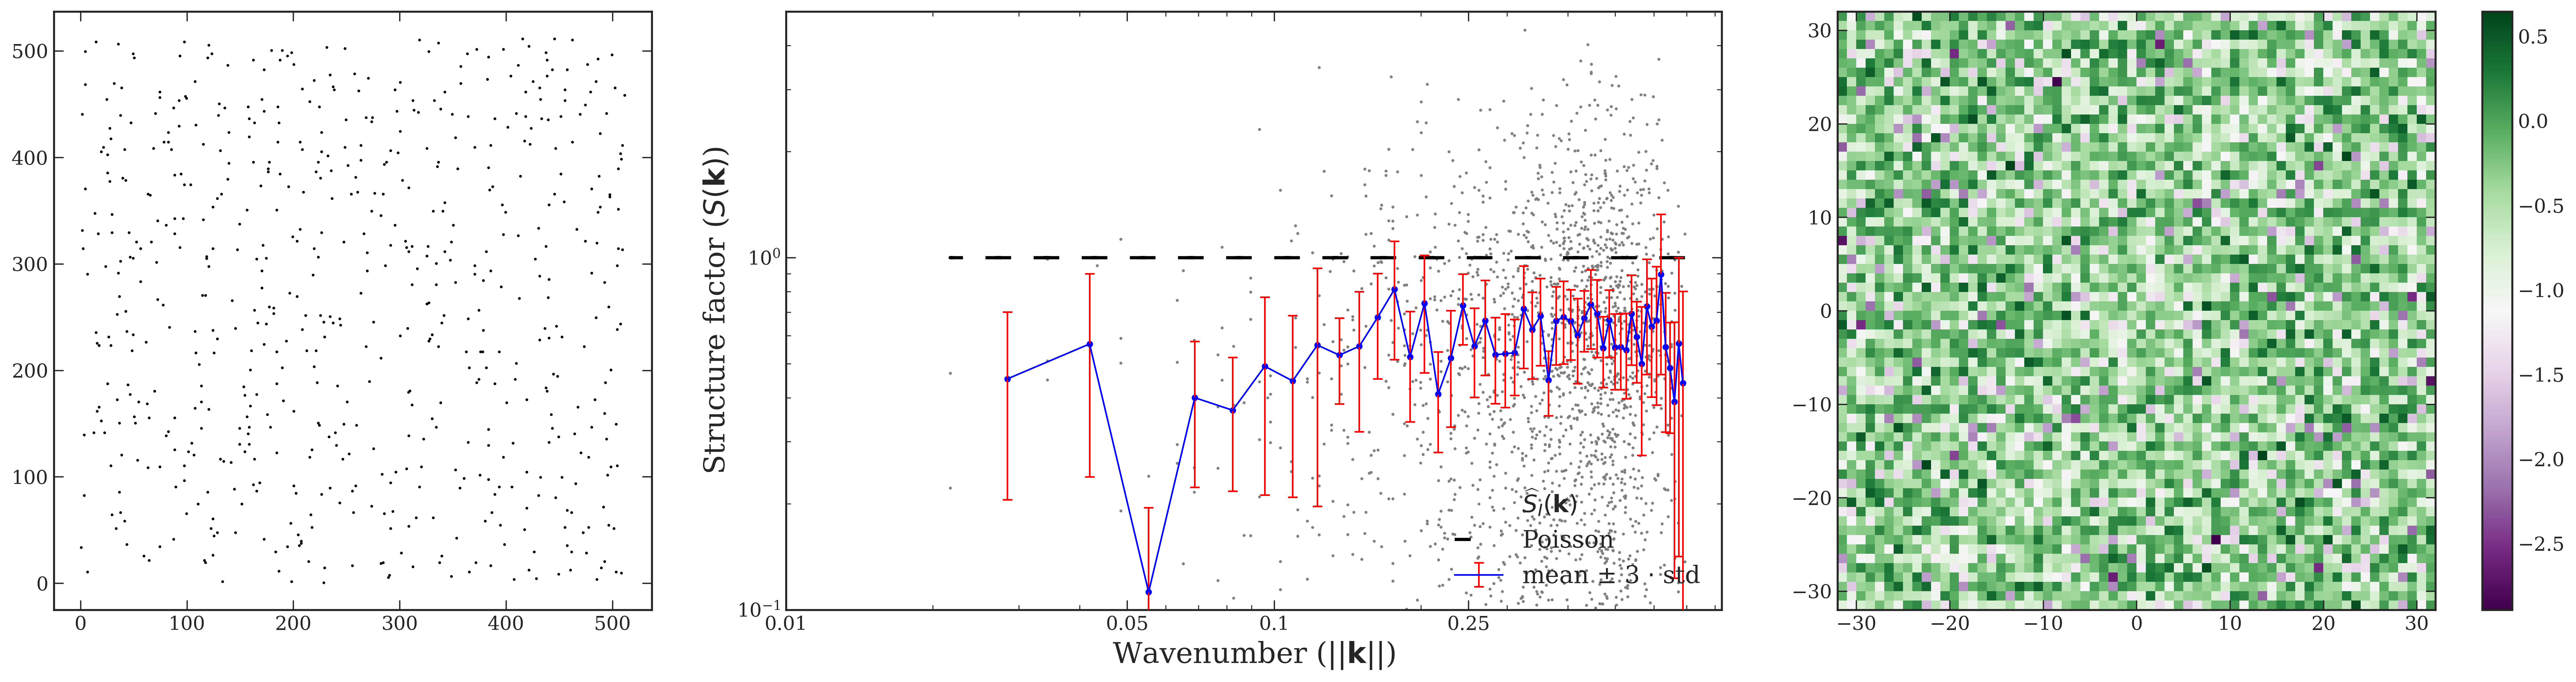

In [18]:
axx = sf.plot_non_isotropic_estimator(
    k,
    sf_estimated,
    plot_type="all",
    error_bar=True,
    bins=50,
    label=r"$\widehat{S}_I (\mathbf{k})$",
)
axx[1].set_xticks([0.01, 0.05, 0.1, 0.25], [0.01, 0.05, 0.1, 0.25]);
axx[1].set_ylim([0.1,5])

In [73]:
frame_interval = [0, 1]

LX, LY = ar._read_frame(0).LX, ar._read_frame(0).LY
rmax = LX/4 - 1
window = BallWindow(center=[LX/2, LX/2], radius=LX/2-1) 
#window = BoxWindow(bounds=[[0, LX], [0, LY]])   

rad_arr, pcf_arr = get_pair_corr_function(ar, window, frame_interval = frame_interval, rmax = rmax, method = "fv", \
                            method_kwargs = dict(method="b", spar=0.2, nknots = 50))

R[write to console]: number of data points exceeds 3000 - computing border correction estimate only



In [67]:

window = BoxWindow(bounds=[[0, LX], [0, LY]])   
top_defect_list = get_defect_list(ar, LX, LY, frame_interval[0], frame_interval[1])

kbins, sf_arr = get_structure_factor(ar, window, frame_interval = frame_interval, kmax = .5, debiased = True, direct = True, nbins = 50,)

Time for structure factor: 13.647084712982178


R[write to console]: number of data points exceeds 3000 - computing border correction estimate only



Time for pair correlation function: 3.3769824504852295


In [31]:


def plot_structure_factor(kbins, smeans, sstds, k = None, plot_scaling=False, LX = None, sf_estimated = None):
    """
    Plot structure factor
    """

    k_begin_lines_idx = 10
    kmin, kmax = np.nanmin(kbins), np.nanmax(kbins)
    sf_min, sf_max = np.nanmin(smeans), np.nanmax(smeans)
    x = np.linspace(kmin, kbins[k_begin_lines_idx], 10)

    ratio = 4.5 / 7
    w = 7.5
    h = w * ratio
    fig, ax = plt.subplots(ncols=1,figsize=(w, h))
  
    if k and sf_estimated:
        ax.scatter(np.linalg.norm(k, axis = 1), sf_estimated, label='Structure factor', s=2.5, alpha=0.3)

    ax.hlines(1, 0, kmax, label=r'Possion', linestyles='dashed', colors='k')
    ax.errorbar(kbins, smeans, yerr = sstds, fmt = 's-', label = 'Binned means', alpha = .8, color = 'red', ecolor = 'black', markersize = 5)

    if plot_scaling:
        ax.plot(x, smeans[k_begin_lines_idx] * x**0.1 / x[-1]**0.1, label=r'$k^{0.1}$')
        ax.plot(x, smeans[k_begin_lines_idx] * x**0.2 / x[-1]**0.2, label=r'$k^{0.2}$')
        ax.plot(x, smeans[k_begin_lines_idx] * x**0.3 /x[-1]**0.3, label=r'$k^{0.3}$')

    ax.set_xscale('log')
    ax.set_yscale('log')
 #   ax.set_xticks(np.logspace(np.log10(kmin), np.log10(kmax), 5), np.round(np.logspace(np.log10(kmin), np.log10(kmax), 5),3))   
    
 #   ax.set_ylim([sf_min/4, sf_max + 3])
  #  ax.set_xlim([kmin - 0.01, kmax + 0.1])
    ax.legend(ncol=3, fontsize = 14)
    ax.set_xlabel(r'Norm of wavenumber ($k$)')
    ax.set_ylabel(r'Structure factor')

    if LX == 2048:
            ax.set_xticks([kmin, 0.01, 0.1, kmax], [np.round(kmin,3), 0.01, 0.1, np.round(kmax,1)])
            ax.set_yticks([0.3, 0.4, 0.6, 1, 5], [0.3, 0.4, 0.6, 1, 5])
    else:
        ax.set_xticks([kmin, 0.1, kmax], [np.round(kmin,3), 0.1, np.round(kmax,1)])
    #    ax.set_yticks([0.3, 0.4, 0.6, 1,], [0.3, 0.4, 0.6, 1,])

    return fig, ax




In [ ]:
fig, ax = plot_structure_factor(kbins, sf_arr[-1, :, 0], sf_arr[-1, :, 1]);
ax.plot(knorms,sf_estimated, 'g.', markersize=3, alpha=.4)
#ax.set(yticks=np.logspace(-3,1,10), yticklabels=np.round(np.logspace(-3,1,10),3))
ax.set_ylim([0.001,10])
fig.dpi = 720

